## RBF code for the AJP article

### The program solves the Laplace equation using the RBF  collocation method, $\nabla^2 u = 0 $. The system configuration consists of two parallel plates inside a long, grounded cylinder. Other systems can be solved by modifying the initialization function.

In [3]:
#
# Calculate potential of parallel plates in a cylinder
# Wang and Hao, Physics, UMass Dartmouth
#

from scipy.linalg import solve
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D     # for surface plots
%matplotlib inline                        

### Initialization block

### First, set boundary nodes on circle with boundary values 0, then on the two plates with boundary values  $\pm 1$, respectively. Next, place random Halton points inside the circle, excluding region close to the plates.

In [4]:
# initialize(): R=radius, L = length, d = separation
# 4*M = nodes on circle, N = approx number of nodes across diameter
def initialize(R, L, d, M=20, N=20):    # set up nodes and boundary values
    inode, bnode, b = [], [], []        # intnl, bndry nodes, bndry values
    K, tol = N//2, 0.05                 # tol = tolance from boundary
    
    bnode, b = circle_bc(R, M, 0.)      # get nodes on circle
    xp = np.linspace(-L/2, L/2, K)      # nodes across plates
    bnode += [[xp[i], d/2] for i in range(K)]   # top, bottom
    bnode += [[xp[i], -d/2] for i in range(K)]
    b += [1.]*K + [-1.]*K                       # +/- 1
        
    x = (2*halton(N*N, 3) - 1)*R        # (x,y) nodes in [-R, R]
    y = (2*halton(N*N, 2) - 1)*R        # use diff bases
    for (x, y) in zip(x, y):
        if (x*x + y*y < (1-tol)*R*R):   # internal nodes, inside circle
            dy = abs(y) - d/2
            if not (abs(dy) < tol*d and abs(x) < (1+tol)*L/2): # not on plates
                inode.append([x, y])
    ni, node = len(inode), inode+bnode          # combine nodes 
    return np.array(node), [0.]*ni+b, ni, len(node)

# Halton sequence; return 1st n terms in base b (prime num, default: 2)
def halton(n=10, b=2):
    m = 1 + int(np.log(n)/np.log(b))        # base digits
    c = [1./b**(i+1) for i in range(m)]     # fractions
    d, h = [0]*m, [0.]*n
    for i in range(n):
        d[0] += 1               # increment seq.
        for j in range(m):      
            if (d[j] + 1 > b):  # carry in base b
                d[j] = 0                
                d[j+1] += 1                         
            h[i] += c[j]*d[j]   # sum up fractions
    return np.array(h)
    
# set 4*M boundary nodes on circle; or M = number on a quarter circle
def circle_bc(R = 1., M = 20, bval = 0.):    
    theta = np.linspace(0, 2*np.pi, 4*M)[:-1]      # angles: 0,2*pi same
    x, y = R*np.cos(theta), R*np.sin(theta)
    bnode = [[x[i],y[i]] for i in range(len(x))]   # boundary nodes
    b = [bval]*len(bnode)       # set bndy value
    return bnode, b

### The RBF block outputs RBF values $\phi_i(\vec{r})$, the operator matrix $\nabla^2 \phi_i(\vec{r})|_{\vec{r}_j}$, and the interpolant $u=\sum_i a_i \phi_i(\vec{r})$

In [5]:
def phi(i, r):              # MQ RBF, $\phi_i$ and $\nabla^2 \phi_i$
    r2, e2 = (node[i,0]-r[0])**2 + (node[i,1]-r[1])**2, eps*eps
    f = np.sqrt(1+e2*r2)
    return f, e2*(1+f*f)/(f*f*f)

def rbf_mat(ni, nt):        # fills matrix $A_{ij} = \nabla^2_j \phi_i$ or $\phi_{ij}$
    A = np.zeros((nt, nt))
    for j in range(nt):
        f, df = phi(np.arange(nt), node[j])  # vector operation 
        A[j,:] = df if j < ni else f
    return A    

def usum(a, x, y):          # calc u at (x,y) from interpolant
    u = 0.
    for i in range(len(a)):
        u += a[i]*phi(i, [x, y])[0]     # [0]= first returned value 
    return u

### Computation

In [6]:
R, eps = 1.0, 20.           # radius of circle, shape parameter
L, d = 0.8*R, 0.4*R         # length, separation of plates

node, b, ni, nt = initialize(R, L, d, M=70, N=70)    # initialize
print ('number of internal, total nodes:', ni, nt)

A = rbf_mat(ni, nt)         # build system matrix
ai = solve(A, b)            # solve 

x = np.linspace(-R, R, 81)   # compute u on (x,y) plotting grids
x, y = np.meshgrid(x, x)
u = usum(ai, x, y)
Ey, Ex = np.gradient(-u)    # add E field (row=y, column=x)

number of internal, total nodes: 3582 3931


### Plot results

(Text(0.5, 0, '$x$'), Text(0, 0.5, '$y$'))

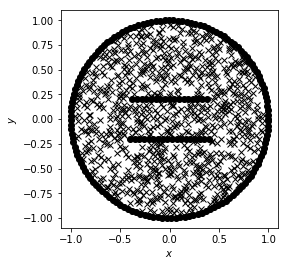

In [7]:
fig=plt.figure()            # plot nodes
ax = fig.add_subplot(111, aspect='equal')
plt.plot(node[:ni:4,0], node[:ni:4,1], 'kx')    # internal, skip=4
plt.plot(node[ni::2,0], node[ni::2,1], 'ko')    # boundary, skip=2
plt.xlabel('$x$'), plt.ylabel('$y$')

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'lw'
  s)


(Text(0.5, 0, '$x$'), Text(0, 0.5, '$y$'))

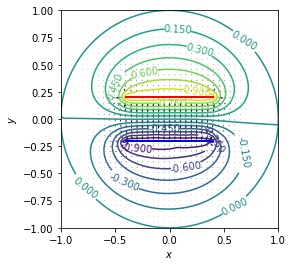

In [8]:
fig=plt.figure()            # plot contour and E field vector
ax = fig.add_subplot(111, aspect='equal') 
ct = plt.contour(x, y, u, 15, lw=1.5)
plt.clabel(ct)

plt.quiver(x[::2,::2], y[::2,::2], Ex[::2,::2], Ey[::2,::2],    # stride 2
           width=0.004, minshaft=1.5, minlength=0, scale=6.)
plt.plot([-L/2,L/2],[d/2,d/2],'-r',lw=2)        # plates
plt.plot([-L/2,L/2],[-d/2,-d/2],'-b',lw=2)
plt.xlabel('$x$'), plt.ylabel('$y$')

(<matplotlib.text.Text at 0x46802b0>,
 <matplotlib.text.Text at 0x6c1b470>)

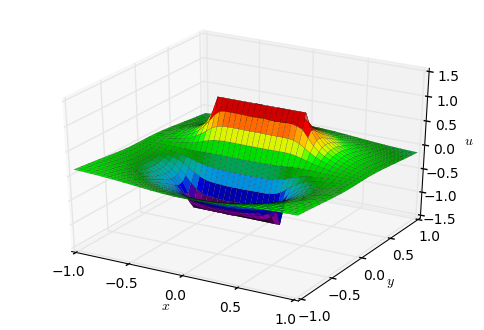

In [7]:
fig = plt.figure()          # add surface plot
axis=fig.add_subplot(111, projection='3d')  # add subplot
axis.plot_surface(x[::2,::2], y[::2,::2], u[::2,::2], rstride=1, cstride=1,
                  linewidth=0.1, cmap=plt.cm.spectral)
plt.xlabel('$x$'), plt.ylabel('$y$'), axis.set_zlabel('$u$')  